In [1]:
%matplotlib inline
# disable autoreload for global dataset
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [3]:
from learn import *
from gen_val_postproc_building import *

In [4]:
num_gpus = 1
gpu_start = 6
num_workers = 3 * num_gpus
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

bs = 4

## Plot predictions

In [5]:
model_name = 'deeplab'

In [6]:
data = None
print(datapaths)

['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']


In [8]:
#resume
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name=model_name,
                                         debug=False, global_dataset=True, data=data, num_slice=9, sz=256)
(trn_x,trn_y), (val_x,val_y) = data

HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

MemoryError: 

## plots

In [ ]:
learn.load('deeplab-vegas')

In [ ]:
%%time
preds = learn.predict()

In [ ]:
# jaccard coefficient for whole dataset
jaccard_co

In [377]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]

CPU times: user 11.4 s, sys: 2.08 s, total: 13.5 s
Wall time: 2.12 s


In [378]:
len(x)

450

In [379]:
thresh = np.linspace(0, 1, 20)

In [380]:
score = [jaccard_coef(T(preds), T(bool_pred(y, t).astype('float'))) for t in thresh]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
plt.plot(thresh, score)

In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=50,
                          scores=scores, is_best=1, thresh=0.5)

In [ ]:
idx

## CRF

In [ ]:
from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger

In [ ]:
data_train = pickle.load(open("data_train_dict.pickle"))
C = 0.01

n_states = 21
print("number of samples: %s" % len(x))
class_weights = 1. / np.bincount(np.hstack(y))
class_weights *= 21. / np.sum(class_weights)

In [86]:
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle

from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger


data_train = pickle.load(open("data_train_dict.pickle"))
C = 0.01

n_states = 21
print("number of samples: %s" % len(data_train['X']))
class_weights = 1. / np.bincount(np.hstack(data_train['Y']))
class_weights *= 21. / np.sum(class_weights)
print(class_weights)

model = crfs.EdgeFeatureGraphCRF(inference_method='qpbo',
                                 class_weight=class_weights,
                                 symmetric_edge_features=[0, 1],
                                 antisymmetric_edge_features=[2])

experiment_name = "edge_features_one_slack_trainval_%f" % C

ssvm = learners.NSlackSSVM(
    model, verbose=2, C=C, max_iter=100000, n_jobs=-1,
    tol=0.0001, show_loss_every=5,
    logger=SaveLogger(experiment_name + ".pickle", save_every=100),
    inactive_threshold=1e-3, inactive_window=10, batch_size=100)
ssvm.fit(data_train['X'], data_train['Y'])

data_val = pickle.load(open("data_val_dict.pickle"))
y_pred = ssvm.predict(data_val['X'])

# we throw away void superpixels and flatten everything
y_pred, y_true = np.hstack(y_pred), np.hstack(data_val['Y'])
y_pred = y_pred[y_true != 255]
y_true = y_true[y_true != 255]

print("Score on validation set: %f" % np.mean(y_true == y_pred))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

### Guided Filter

In [68]:
x.shape

(450, 3, 256, 256)

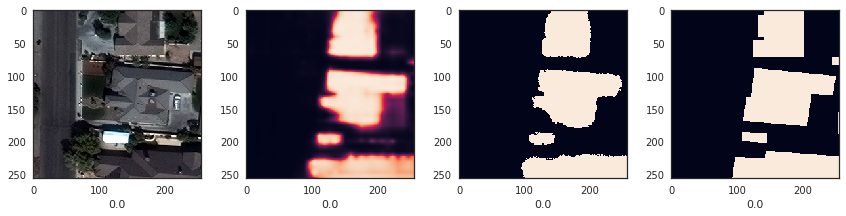

In [368]:
idx = 263
guide = (denorm(x[idx]).squeeze() * 255).astype('uint8')
gt = (y[idx] * 255).astype('uint8')
src = (np.copy(preds[idx] ) * 255).astype('uint8')
dst = np.empty(src.shape)
radius = 6
eps = 28

filtered = cv2.ximgproc.guidedFilter(guide, src, radius, eps, dst, -1)
col1 = [guide]
col2 = [src]
col3 = [filtered > 255//2]
data = zip(col1, col2, col3, [y[idx]])

plot_ims(data, figsize=3)

In [ ]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    filtered_whole = e.map(
        partial(cv2.ximgproc.guidedFilter, guide=guide, src, radius, e, eps))

In [363]:
rows, cols = 10, 20
radius = np.arange(0, 10, 1).astype('uint8')
eps = np.arange(10, 30, 20/cols).astype('uint8')
res = np.empty([rows, cols] + list(src.shape))
for row, r in enumerate(radius):
    for col, e in enumerate(eps):    
        res[row, col] = cv2.ximgproc.guidedFilter(guide, src, r, e, )

In [364]:
score_mat = np.empty([rows, cols])
for row, r in enumerate(radius):
    for col, e in enumerate(eps): 
        score_mat[row, col] = jaccard_coef(res[row, col], gt, thresh=255//2)

In [365]:
score_mat.reshape(-1,)[score_mat.argmax()], jaccard_coef(src, gt, thresh=255//2)

(0.8771794252595991, 0.8726099194409396)

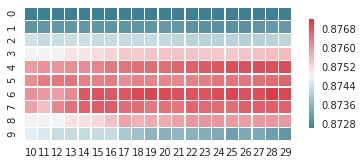

In [366]:
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(score_mat, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
_ = ax.set_xticklabels(eps)

In [367]:
score_mat.argmax()

138

### Contour

In [38]:
class args:
    def __init__(self, val_dir):
        self.val_dir = val_dir
        self.save_dir = 'data/working/images/v5/save_paris/'
        self.stride = 24
        self.batch = 7
        self.proc_method = None
        self.resize = 1
        self.map_size = 256

In [39]:
pred_images(learn, args('data/working/images/v5/test_full_rgb/paris'))

Read images in data/working/images/v5/test_full_rgb/paris
345 images found!
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img332.png
0 data/working/images/v5/save_paris/AOI_3_Paris_imgmask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img1154.png
0 data/working/images/v5/save_paris/AOI_3_Paris_img1mask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img1071.png
0 data/working/images/v5/save_paris/AOI_3_Paris_img1mask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img4.png
0 data/working/images/v5/save_paris/AOI_3_Paris_imask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img1277.png
0 data/working/images/v5/save_paris/AOI_3_Paris_img1mask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AOI_3_Paris_img1047.png
0 data/working/images/v5/save_paris/AOI_3_Paris_img1mask.png
==== Reading === data/working/images/v5/test_full_rgb/paris/AO

KeyboardInterrupt: 